In [131]:
import nltk
nltk.word_tokenize("uncounted military absentee ballots delivered voting deadline would 2012 presidential election mitt romney	 	1682	is trending on facebook right now hot topics will ferrell godzilla chad smith gareth edwards star wars morgan freeman lucasfilm tweet trending story share it military absentee ballots delivered one day late share on facebook share on twitter would uncounted military absentee ballots delivered after the voting deadline have won the 2012 presidential election for mitt romney source main page current trends more about 2012 presidential election military absentee ballots mitt romney share on facebook share on twitter trendline reddit submissions about this your comments")

['uncounted',
 'military',
 'absentee',
 'ballots',
 'delivered',
 'voting',
 'deadline',
 'would',
 '2012',
 'presidential',
 'election',
 'mitt',
 'romney',
 '1682',
 'is',
 'trending',
 'on',
 'facebook',
 'right',
 'now',
 'hot',
 'topics',
 'will',
 'ferrell',
 'godzilla',
 'chad',
 'smith',
 'gareth',
 'edwards',
 'star',
 'wars',
 'morgan',
 'freeman',
 'lucasfilm',
 'tweet',
 'trending',
 'story',
 'share',
 'it',
 'military',
 'absentee',
 'ballots',
 'delivered',
 'one',
 'day',
 'late',
 'share',
 'on',
 'facebook',
 'share',
 'on',
 'twitter',
 'would',
 'uncounted',
 'military',
 'absentee',
 'ballots',
 'delivered',
 'after',
 'the',
 'voting',
 'deadline',
 'have',
 'won',
 'the',
 '2012',
 'presidential',
 'election',
 'for',
 'mitt',
 'romney',
 'source',
 'main',
 'page',
 'current',
 'trends',
 'more',
 'about',
 '2012',
 'presidential',
 'election',
 'military',
 'absentee',
 'ballots',
 'mitt',
 'romney',
 'share',
 'on',
 'facebook',
 'share',
 'on',
 'twitter',
 

In [1]:
import sys
# sys.path.insert(0, '../GET')


from Models.FCWithEvidences import graph_based_semantic_structure
from Fitting.FittingFC import char_man_fitter_query_repr1
import time
import json
from interactions import ClassificationInteractions
import matchzoo as mz
from handlers import cls_load_data
import argparse
import random
import numpy as np
import torch
import torch_utils
import numpy as np
import os
import datetime
from handlers.output_handler_FC import FileHandlerFC
from Evaluation import mzEvaluator as evaluator
from setting_keywords import KeyWordSettings
from matchzoo.embedding import entity_embedding
from Models.BiDAF.wrapper import GGNN, GGNN_with_GSL, Linear
from thirdparty.two_branches_attention import *
from transformers import AutoTokenizer, AutoModel
import torch
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset="Snopes"
fixed_length_left=30
fixed_length_right=100
log="logs/get"
loss_type="cross_entropy"
batch_size=32
num_folds=5
use_claim_source=0
use_article_source=1
path="formatted_data/declare/"
hidden_size=300
epochs=100
num_att_heads_for_words=5
num_att_heads_for_evds=2
gnn_window_size=3
lr=0.0001
gnn_dropout=0.2
seed=123756
gsl_rate=0.6
fixed_length_left_src_chars = 20
fixed_length_right_src_chars = 20
seed = 123756
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [134]:
# dataset="PolitiFact"
# fixed_length_left=30
# fixed_length_right=100
# log="logs/get"
# loss_type="cross_entropy"
# batch_size=32
# num_folds=5
# use_claim_source=1
# use_article_source=1
# path="formatted_data/declare/"
# hidden_size=300
# epochs=100
# num_att_heads_for_words=3
# num_att_heads_for_evds=1
# gnn_window_size=3
# lr=0.0001
# gnn_dropout=0.2
# seed=123456
# gsl_rate=0.6
# fixed_length_left_src_chars = 20
# fixed_length_right_src_chars = 20
# seed = 123456
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

In [175]:
query = ["dai hoc","bach koha","ho chi minh"]
length =30

In [176]:
encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
encoded_input

{'input_ids': tensor([[  101, 18765, 21929,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101, 10384, 12849,  3270,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  7570,  9610, 19538,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0,

In [179]:
encoded_input["attention_mask"].size()

torch.Size([3, 31])

In [147]:
query = ["dai hoc","bach koha","ho chi minh"]

In [165]:
encoded_input = tokenizer.encode("dai hoc", padding=True, truncation=True, return_tensors='pt')
res = np.array(encoded_input.squeeze()[1:]).tolist()

In [166]:
res

[18765, 21929, 102]

In [180]:
encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
input = encoded_input["attention_mask"][:,1:]

input.size()

torch.Size([3, 30])

In [163]:
encoded_input["input_ids"][:,1:].size()

torch.Size([3, 30])

In [157]:
res = model(encoded_input["input_ids"][:,1:], attention_mask=encoded_input["attention_mask"][:,1:])

In [159]:
res = model(input)

In [160]:
res.last_hidden_state.size()

torch.Size([3, 30, 384])

In [ ]:
def embedding(self,query,length):
    encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
    model_output = model(**encoded_input)
    return model_output.last_hidden_state.squeeze()[:,1:,:].to("cuda:0")

    # return torch.tensor(np.array([self.get_embedding(x,length) for x in query])).to("cuda:0")
def decode_sentence(self,query_ids): #(B,30)
    return [tokenizer.decode(x, skip_special_tokens=True) for x in query_ids]

In [116]:
encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
model_output = model(**encoded_input)

In [118]:
model_output.last_hidden_state.squeeze().shape

torch.Size([2, 31, 384])

In [ ]:
38400

In [5]:
preprocessor = mz.preprocessors.CharManPreprocessor(fixed_length_left = fixed_length_left,
                                                    fixed_length_right = fixed_length_right,
                                                    fixed_length_left_src = fixed_length_left_src_chars,
                                                    fixed_length_right_src = fixed_length_right_src_chars)

In [6]:
dataset="Snopes"
fixed_length_left=30
fixed_length_right=100
log="logs/get"
batch_size=32
gnn_window_size=3
fold_idx=4
if not os.path.exists(log):
      os.mkdir(log)
secondary_log_folder = os.path.join(log, "log_results_%s" % (dataset))
if not os.path.exists(secondary_log_folder):
  os.mkdir(secondary_log_folder)
secondary_log_folder = secondary_log_folder
root = os.path.join(os.path.join(path,dataset), "mapped_data")
tx = time.time()
kfold_dev_results, kfold_test_results = [], []
list_metrics = KeyWordSettings.CLS_METRICS
outfolder_per_fold = os.path.join(secondary_log_folder, "Fold_%s" % fold_idx)
if not os.path.exists(outfolder_per_fold):
    os.mkdir(outfolder_per_fold)
logfolder_result_per_fold = os.path.join(outfolder_per_fold, "result_%s.txt" % int(seed))
file_handler = FileHandlerFC()
file_handler.init_log_files(logfolder_result_per_fold)
# root ="/content/drive/MyDrive/GET/formatted_data/declare/Snopes/mapped_data"
# ------------------------------------------------------------------------------------
# predict_pack = cls_load_data.load_data(root + "/%sfold" % num_folds,  'test_%s' % 0, kfolds = num_folds)
# train_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'train_%sres' % 0, kfolds = num_folds)
predict_pack = cls_load_data.load_data(root + "/%sfold" % num_folds,  'testnew' , kfolds = num_folds)
train_pack = cls_load_data.load_data(root + "/%sfold" % num_folds, 'trainnew' , kfolds = num_folds)
valid_pack = cls_load_data.load_data(root, 'devnew', kfolds = num_folds)

a = train_pack.left["text_left"].str.lower().str.split().apply(len).max()
b = valid_pack.left["text_left"].str.lower().str.split().apply(len).max()
c = predict_pack.left["text_left"].str.lower().str.split().apply(len).max()
max_query_length = max([a, b, c])
min_query_length = min([a, b, c])

a = train_pack.right["text_right"].str.lower().str.split().apply(len).max()
b = valid_pack.right["text_right"].str.lower().str.split().apply(len).max()
c = predict_pack.right["text_right"].str.lower().str.split().apply(len).max()
max_doc_length = max([a, b, c])
min_doc_length = min([a, b, c])

file_handler.myprint("Min query length, " + str(min_query_length) + " Min doc length " + str(min_doc_length))
file_handler.myprint("Max query length, " + str(max_query_length) + " Max doc length " + str(max_doc_length))
global additional_data
additional_data = {KeyWordSettings.OutputHandlerFactChecking: file_handler,
                    KeyWordSettings.GNN_Window: gnn_window_size}

print('parsing data')

train_processed = preprocessor.fit_transform(train_pack)  # This is a DataPack
valid_processed = preprocessor.transform(valid_pack)
predict_processed = preprocessor.transform(predict_pack)


train_interactions = ClassificationInteractions(train_processed, **additional_data)
valid_interactions = ClassificationInteractions(valid_processed, **additional_data)
predict_interactions = ClassificationInteractions(predict_processed, **additional_data)
file_handler.myprint('done extracting')
  

100%|██████████| 890/890 [00:00<00:00, 61150.47it/s]


100%|██████████| 817/817 [00:00<00:00, 641833.00it/s]

Min query length, 14 Min doc length 100
Max query length, 22 Max doc length 100


parsing data


Processing text_left with chain_transform of Tokenize: 100%|██████████| 111/111 [00:00<00:00, 3214.03it/s]
Processing text_right with chain_transform of Tokenize: 100%|██████████| 993/993 [00:00<00:00, 1908.47it/s]
Processing text_right with chain_transform of Tokenize: 100%|██████████| 111/111 [00:00<00:00, 309965.21it/s]
Building Entities Vocabulary from a datapack.: 100%|██████████| 111/111 [00:00<00:00, 2050959.22it/s]
Processing text_right with chain_transform of Tokenize: 100%|██████████| 993/993 [00:00<00:00, 920429.58it/s]
Building Entities Vocabulary from a datapack.: 100%|██████████| 993/993 [00:00<00:00, 3450657.72it/s]
Processing text_right with chain_transform of Tokenize: 100%|██████████| 111/111 [00:00<00:00, 376368.43it/s]
Processing text_right with chain_transform of Tokenize: 100%|██████████| 993/993 [00:00<00:00, 490397.25it/s]
Building Characters Vocabulary from a datapack.: 100%|██████████| 18144/18144 [00:00<00:00, 3922957.46it/s]
Processing text_right with chain_

Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id



/Users/namle/Library/CloudStorage/GoogleDrive-hcmutepfl@gmail.com/My Drive/GET/interactions.py:15: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
Converting DataFrame to Normal Dictionary of Data
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
[NOTICE] MatchZoo use queryID and docID as index in dataframe left and right, therefore, iterrows will return index which is left_id or right_id
done extracting


In [7]:
train_interactions.dict_doc_raw_contents

{17409: 'the big picture behind a recent study on sparring mantis shrimp photograph by roy in money best neuroscience images of 2015 the best neuroscience images from the queensland brain institute for 2015 have been revealed images were submitted into the categories artistic life sciences shrimp crock tale claim image depicts a 102 lb shrimp caught near homosassa florida false example collected via facebook november 2015 origins on 6 november skepticism new form of secret light language keeps other animals in the dark a new form of secret light communication used by marine animals has been discovered by researchers from the',
 18619: 'texas girl impregnated by flu summary of a texas girl was made pregnant by a flu shot the truth a fake news website is behind this hoax world news daily report started that rumor with a story headlined texas old virgin falls pregnant after flu shot the story reports the girl experienced nausea and severe cramps after receiving the vaccine san angelo tx a

In [189]:
train_interactions.dict_query_raw_contents
train_interactions.dict_doc_raw_contents

{2586: 'image depicts 102 lb shrimp caught near homosassa florida',
 2762: 'girl became pregnant receiving flu shot',
 898: 'donald trump said 1998 would one day run republican dumbest group voters',
 2463: 'actor jack nicholson said positively abortion',
 4055: 'photograph shows 41 lb rat caught new york city',
 237: 'uncounted military absentee ballots delivered voting deadline would 2012 presidential election mitt romney',
 3519: 'obama administration planning launch america scouts youth program',
 1270: 'female senators showed work congress following snowstorm jonas',
 1344: 'restaurant chain driven bankruptcy offering free alcohol veterans day',
 1739: 'obama administration selling blueprints b2 stealth bomber china exchange debt relief',
 2038: 'chris brown posted bail ariel castro arrested holding three women captive ten years',
 3057: 'accidental spill rendered normally pristine blue animas river terrifying mustard yellow',
 3680: 'joe biden endorsed mitt romney president',
 15

In [73]:
type(train_interactions)

interactions.ClassificationInteractions

In [185]:
# doc_id, doc_label, doc_content, doc_len, docs_adj
train_interactions.dict_claims_and_evidences_test[2762][2]

[[1037,
  3146,
  2611,
  2001,
  2081,
  6875,
  2011,
  19857,
  2915,
  1996,
  3606,
  8275,
  2739,
  4037,
  2003,
  2369,
  2023,
  28520,
  2088,
  3679,
  3189,
  2318,
  2008,
  19075,
  2007,
  2466,
  25214,
  2214,
  6261,
  4212,
  2044,
  4311,
  5281,
  19029,
  1998,
  5729,
  13675,
  25167,
  4909,
  17404,
  2624,
  12262,
  19067,
  2082,
  15239,
  2038,
  4265,
  3809,
  12763,
  9382,
  2187,
  2402,
  16668,
  5665,
  2127,
  2155,
  3460,
  2633,
  3651,
  3134,
  2101,
  2016,
  2018,
  2042,
  17727,
  2890,
  16989,
  3064,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [17727,
  2890,
  16989,
  3064,
  2013,
  1996,
  19857,
  2915,
  5351,
  2255,
  2325,
  2011,
  1015,
  7615,
  4366,
  1037,
  2403,
  2095,
  2214,
  2611,
  2001,
  2044,
  7940,
  5246,
  3161,
  13323,
  6270,
  19200,
  2008,
  3146,
  2150,
  4909,
  2024,
  9359,
 

In [42]:
id_left = [2586,2762,898,2463]

In [51]:
def decode_sentence(query_ids):
    return [tokenizer.decode(x, skip_special_tokens=True) for x in query_ids]

In [52]:
res = decode_sentence(res)

In [53]:
res

['image depicts 102 lb shrimp caught near homosassa florida',
 'girl became pregnant receiving flu shot',
 'donald trump said 1998 would one day run republican dumbest group voters',
 'actor jack nicholson said positively abortion']

In [65]:

def decode_sentence(query_ids):
    return [tokenizer.decode(x, skip_special_tokens=True) for x in query_ids]
def embedding(query,length):
        encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
        model_output = model(**encoded_input)
        return model_output.last_hidden_state.squeeze()[:,1:,:]
res = [train_processed.left["text_left"][i] for i in id_left]
res = decode_sentence(res)
embedding(res,30).size()

torch.Size([4, 30, 384])

In [57]:
res = embedding(res,30)

In [60]:
res.size(0)


3

In [63]:
def get_embedding(sentence,length):
    encoded_input = tokenizer(sentence, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
    model_output = model(**encoded_input)
    return model_output.last_hidden_state.squeeze()[1:].cpu().detach().numpy()
def embedding(query,length):
        # encoded_input = tokenizer(query, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
        # model_output = model(**encoded_input)
        # return model_output.last_hidden_state.squeeze()[1:].to("cuda:0")

        return torch.tensor(np.array([get_embedding(x,length) for x in query]))
def decode_sentence(query_ids):
    return [tokenizer.decode(x, skip_special_tokens=True) for x in query_ids]
res = decode_sentence(res)
test = embedding(res,30)
test.size()

torch.Size([4, 30, 384])

In [47]:
res

[[3746, 11230, 9402, 6053, 20130, 3236, 2379, 24004, 20939, 3736, 3516, 102],
 [2611, 2150, 6875, 4909, 19857, 2915, 102],
 [6221,
  8398,
  2056,
  2687,
  2052,
  2028,
  2154,
  2448,
  3951,
  12873,
  4355,
  2177,
  7206,
  102],
 [3364, 2990, 16955, 2056, 13567, 11324, 102]]

In [8]:
decoded_text = tokenizer.decode(res, skip_special_tokens=True)
decoded_text

'meijer offering 100 back school coupons'

In [76]:
encoded_input = tokenizer(decoded_text, padding=True, truncation=False, return_tensors='pt')
model_output = model(**encoded_input)

In [77]:
model_output.last_hidden_state.size()

torch.Size([1, 8, 384])

In [33]:
lst =["dai hoc","bach khoa thanh pho",'Ho chi minh']

In [43]:
def f(lst):
    encoded_input = tokenizer(lst, padding=True, truncation=False, return_tensors='pt')
    model_output = model(**encoded_input)
    return model_output.last_hidden_state.squeeze()[1:-1]

In [21]:
def get_embedding(sentence,length):
    encoded_input = tokenizer(sentence, padding="max_length", truncation=False, return_tensors='pt',max_length=(length+1))
    model_output = model(**encoded_input)
    return model_output.last_hidden_state.squeeze()[1:].cpu().detach().numpy()

In [28]:
def embedding(query,length):
        return torch.tensor(np.array([get_embedding(x,length) for x in query]))

In [29]:
embedding(sentence,20).shape

torch.Size([3, 20, 384])

In [11]:
sentence = ["âhha",'hâh','hádhsdh']

In [13]:
encoded_input = tokenizer(sentence, padding="max_length", truncation=False, return_tensors='pt',max_length=20)
model_output = model(**encoded_input)

In [15]:
model_output.last_hidden_state.squeeze()[1:].cpu().detach().numpy()

array([[[-0.28420752, -0.3380757 , -0.24664336, ...,  0.4771437 ,
          0.23449118,  0.25058946],
        [-0.74243116, -0.0234914 , -0.22976226, ...,  0.15796897,
          0.03672373,  0.24914274],
        [-0.5784463 , -0.15933019,  0.08002027, ...,  0.08575569,
          0.18449906,  0.34525913],
        ...,
        [-0.28419995, -0.33806264, -0.24664381, ...,  0.4771142 ,
          0.23450872,  0.2505927 ],
        [-0.28419942, -0.338062  , -0.24664348, ...,  0.4771121 ,
          0.23451068,  0.25059664],
        [-0.284199  , -0.33806178, -0.24664417, ...,  0.47711372,
          0.23450956,  0.25059548]],

       [[-0.03288646,  0.32396704,  0.13547707, ...,  0.4808771 ,
          0.09024714,  0.23722702],
        [ 0.01437196,  0.11462063,  0.57455647, ...,  0.18944606,
         -0.6808518 ,  0.8516063 ],
        [ 0.03524441,  0.3591684 ,  0.08808639, ...,  0.22196764,
          0.12400601,  0.29434022],
        ...,
        [-0.0328735 ,  0.32398027,  0.13547951, ...,  

In [70]:
text1 = "This is a short sentence."
text2 = "This is a longer sentence to test padding."
target_length = 20  # Define the desired padded length

# Encode and pad the texts with truncation (optional)
encoded_inputs = tokenizer(
    [text1, text2], padding="max_length", truncation=True, return_tensors="pt", max_length=31)

print(encoded_inputs["input_ids"])  # This will show the padded token IDs
# Access the tokenizer vocabulary (optional)

tensor([[  101,  2023,  2003,  1037,  2460,  6251,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2023,  2003,  1037,  2936,  6251,  2000,  3231, 11687,  4667,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


In [44]:
embed = [ f(x) for x in lst]

In [50]:
embed[1].size()

torch.Size([8, 384])

In [51]:
encoded_input = tokenizer(lst, padding=True, truncation=False, return_tensors='pt')
model_output = model(**encoded_input)

In [52]:
encoded_input.input_ids

tensor([[  101, 18765, 21929,   102,     0,     0,     0,     0,     0,     0],
        [  101, 10384,  1047,  6806,  2050,  2084,  2232,  6887,  2080,   102],
        [  101,  7570,  9610, 19538,   102,     0,     0,     0,     0,     0]])

In [67]:
model_output.last_hidden_state[0][5][100]


tensor(-0.3702, grad_fn=<SelectBackward0>)

In [66]:
model_output.last_hidden_state[0][6][100]


tensor(-0.3702, grad_fn=<SelectBackward0>)

In [11]:
valid_processed.left.text_left

id_left
4273    [9383, 2015, 3696, 28049, 8859, 2224, 2413, 14...
Name: text_left, dtype: object

In [8]:
print("Loading word embeddings......")
t1_emb = time.time()
# term_index = preprocessor.context['vocab_unit'].state['term_index']
# glove_embedding = mz.datasets.embeddings.load_glove_embedding_FC(dimension = 300,
#                                                                   term_index = term_index, **additional_data)

# embedding_matrix = glove_embedding.build_matrix(term_index)
entity_embs1 = entity_embedding.EntityEmbedding(128)
claim_src_embs_matrix = entity_embs1.build_matrix(preprocessor.context['claim_source_unit'].state['term_index'])

entity_embs2 = entity_embedding.EntityEmbedding(128)
article_src_embs_matrix = entity_embs2.build_matrix(preprocessor.context['article_source_unit'].state['term_index'])

t2_emb = time.time()
print("Time to load word embeddings......", (t2_emb - t1_emb))

Loading word embeddings......
Time to load word embeddings...... 0.00821995735168457


In [9]:
match_params = {}
# match_params['embedding'] = embedding_matrix
match_params["num_classes"] = 2
match_params["fixed_length_right"] = 100
match_params["fixed_length_left"] = 30

# for claim source
match_params["use_claim_source"] = use_claim_source
match_params["claim_source_embeddings"] = claim_src_embs_matrix
# for article source
match_params["use_article_source"] = use_article_source
match_params["article_source_embeddings"] = article_src_embs_matrix
# multi-head attention
match_params["cuda"] = 0
match_params["num_att_heads_for_words"] = num_att_heads_for_words  # first level
match_params["num_att_heads_for_evds"] = num_att_heads_for_evds  # second level


match_params['dropout_gnn'] = 0.2
match_params["dropout_left"] = 0.2
match_params["dropout_right"] = 0.2
match_params["hidden_size"] = hidden_size

match_params["gsl_rate"] = 0.6

match_params["embedding_freeze"] = True
match_params["output_size"] = 2 # if args.dataset == "Snopes" else 3
match_params["use_transformer"] = True
match_model = graph_based_semantic_structure.Graph_basedSemantiStructure(match_params)

# match_model.load_state_dict(torch.load("/Users/namle/Library/CloudStorage/GoogleDrive-hcmutepfl@gmail.com/My Drive/GET/logs/get/log_results_Snopes_0.05/Fold_1/saved_model_123756",map_location=torch.device('cpu')))
import datetime
from handlers.output_handler_FC import FileHandlerFC
loss_type = 'cross_entropy'
epochs = 100
batch_size = 32
lr = 0.001
early_stopping = 10
outfolder_per_fold = "logs/get/log_results_Snopes/Fold_10"
curr_date = datetime.datetime.now().timestamp()
fixed_num_evidences = 30
file_handler = FileHandlerFC()
file_handler.init_log_files("huhu")
seed = 123756
args ={}
args["use_noise"] =False
fit_model = char_man_fitter_query_repr1.CharManFitterQueryRepr1(net = match_model, loss = loss_type, n_iter = epochs,
                                                  batch_size = batch_size, learning_rate = lr,
                                                  early_stopping = early_stopping, use_cuda = 0,
                                                  logfolder = outfolder_per_fold, curr_date = curr_date,
                                                  fixed_num_evidences = fixed_num_evidences,
                                                  output_handler_fact_checking = file_handler, seed=seed,
                                                  output_size=match_params["output_size"],args=args)

In [168]:
fit_model.fit(train_interactions, verbose = False,  # for printing out evaluation during training
            # topN = args.topk,
            val_interactions=valid_interactions,
            test_interactions=predict_interactions)

Using: <function cross_entroy at 0x7f8e7be25af0>


KeyboardInterrupt: 

In [12]:
query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(valid_interactions,
                                                                                   fit_model.fixed_num_evidences)

In [13]:
query_ids.shape

(142,)

In [14]:
from transformers import AutoTokenizer, AutoModel
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [15]:
def embedding(query,length):
        mask = (query >= 1)
        query =query
        res = model(query, attention_mask=mask)
        return res.last_hidden_state


In [21]:
left_contents.shape

(142, 30)

In [22]:
res = embedding(torch.tensor(left_contents),30)


In [23]:
res.size()

torch.Size([142, 30, 384])

In [173]:
left_contents.shape

(3126, 30)

In [112]:
evd_cnt_each_query

array([1, 5, 9, ..., 4, 1, 3])

In [107]:
query_ids.shape

(3126,)

In [106]:
evd_docs_ids.shape

(3126, 30)

In [14]:
n = len(query_ids)
idx = np.array(torch.randint(0, n, (n, 2)))

weight = np.array(torch.rand(n).unsqueeze(1))

In [15]:
term_index

NameError: name 'term_index' is not defined

In [16]:
pair_labels[-20:-1]

array([], dtype=int64)

In [17]:
query_ids.shape

(1,)

In [18]:
left_contents[0]

array([ 4895,  3597, 16671,  2098,  2510,  9962,  4402, 17069,  5359,
        6830, 15117,  2052,  2262,  4883,  2602, 10210,  2102, 19615,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [19]:
query_ids, query_contents, query_lengths, query_sources, query_char_source, query_adj,\
               evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, \
               evd_docs_char_source_contents, query_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,
                                                                                   fit_model.fixed_num_evidences)
query_ids_new, query_contents_new, query_lengths_new, query_sources_new, query_char_source_new, query_adj_new,\
        evd_docs_ids_new, evd_docs_contents_new, evd_docs_lens_new, evd_sources_new, evd_cnt_each_query_new, \
        evd_docs_char_source_contents_new, query_labels_new, evd_docs_adj_new = query_ids, query_contents, query_lengths, query_sources, query_char_source, query_adj,\
        evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, \
        evd_docs_char_source_contents, query_labels, evd_docs_adj
# new ood
n = len(query_ids)
idx = np.array(torch.randint(0, n, (n, 2)))

weight = np.array(torch.rand(n).unsqueeze(1))

query_contents_new = query_contents[idx[:, 0]] * weight + query_contents[idx[:, 1]] * (1 - weight)
query_labels_new = np.zeros(query_labels.shape)

query_ids = np.concatenate((query_ids, query_ids_new), axis=0)
query_contents = np.concatenate((query_contents, query_contents_new), axis=0)
query_lengths = np.concatenate((query_lengths, query_lengths_new), axis=0)
query_sources = np.concatenate((query_sources, query_sources_new), axis=0)
query_char_source = np.concatenate((query_char_source, query_char_source_new), axis=0)
query_adj = np.concatenate((query_adj, query_adj_new), axis=0)
evd_docs_ids = np.concatenate((evd_docs_ids, evd_docs_ids_new), axis=0)
evd_docs_contents = np.concatenate((evd_docs_contents, evd_docs_contents_new), axis=0)
evd_docs_lens = np.concatenate((evd_docs_lens, evd_docs_lens_new), axis=0)
evd_sources = np.concatenate((evd_sources, evd_sources_new), axis=0)
evd_cnt_each_query = np.concatenate((evd_cnt_each_query, evd_cnt_each_query_new), axis=0)
evd_docs_char_source_contents = np.concatenate((evd_docs_char_source_contents, evd_docs_char_source_contents_new), axis=0)
query_labels = np.concatenate((query_labels, query_labels_new), axis=0)
evd_docs_adj = np.concatenate((evd_docs_adj, evd_docs_adj_new), axis=0)

In [20]:
evd_docs_adj.shape

(2, 30, 100, 100)

In [21]:
def normalize_matrix(matrix):
    max_val = torch.max(matrix)
    min_val = torch.min(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

def adjacency_matrix_from_matrix(matrix, threshold):
    normalized_matrix = normalize_matrix(matrix)
    size = normalized_matrix.shape[0]
    adjacency_matrix = np.zeros((size, size), dtype=int)

    for i in range(size):
        for j in range(size):
            if normalized_matrix[i][j] >= threshold:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1  # Uncomment if the graph is undirected

    return adjacency_matrix

In [ ]:
def calculate_energy(logit, T=1):
    energy = - T * torch.logsumexp(logit / T, dim=-1)
    return energy

def calculate_adjacency_matrix(output):
    A = output @ output.T
    return A

def create_adjacency_matrix(A, threshold=0.5):
    adjacency_graph = adjacency_matrix_from_matrix(A, threshold)
    return adjacency_graph

def propagate_labels(adjacency_graph, batch_labels):
    mask = np.random.randint(2, size=batch_labels.shape)
    Y_propagation = np.array(batch_labels * (1 - mask))
    score = adjacency_graph @ Y_propagation
    return score

In [ ]:
import gc
def propagate_processing(output, batch_labels, **additional_parameters):

    A = calculate_adjacency_matrix(output)

    adjacency_graph = create_adjacency_matrix(A, threshold=0.5)

    score = propagate_labels(adjacency_graph, batch_labels)
    score = torch.from_numpy(score).unsqueeze(1)

    # Clean up
    del output, A, adjacency_graph

    gc.collect()
    torch.cuda.empty_cache()
    return score

In [ ]:
size = 30
cuda = False
import interactions
import torch_utils as my_utils
energy_train_full = torch.tensor([])
energy_train_ind = torch.tensor([])
energy_train_ood  = torch.tensor([])
energy_test_full  = torch.tensor([])
energy_test_ind = torch.tensor([])
energy_test_ood = torch.tensor([])
energy_full = torch.tensor([])
prob_logit = torch.tensor([])
# interactions: interactions.ClassificationInteractions
query_ind_idx =[]
query_ood_idx = []
import gc



query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
          evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
          pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,fit_model.fixed_num_evidences)

for i in range(pair_labels.shape[0]):
  if pair_labels[i] == 1:
      query_ind_idx.append(i)
  else:
      query_ood_idx.append(i)
logits = torch.tensor([])
outputs = torch.tensor([])
E = torch.tensor([])
with torch.no_grad():

  for (minibatch_num,
                (batch_query, batch_query_content, batch_query_len, batch_query_sources, batch_query_chr_src,
                  batch_query_adj, batch_evd_docs, batch_evd_contents, batch_evd_lens, batch_evd_sources,
                  # i.e. claim source
                  batch_evd_cnt_each_query, batch_evd_chr_src, batch_labels, batch_evd_docs_adj)) \
                    in enumerate(my_utils.minibatch(query_ids, left_contents, left_lengths, query_sources,
                                                    query_char_sources, query_adj,
                                                    evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources,
                                                    evd_cnt_each_query, evd_char_sources, pair_labels, evd_docs_adj,
                                                    batch_size=32)):
      batch_query = my_utils.gpu(torch.from_numpy(batch_query), cuda)
      batch_query_content = my_utils.gpu(torch.from_numpy(batch_query_content), cuda)
      # batch_query_len = my_utils.gpu(torch.from_numpy(batch_query_len), self._use_cuda)
      batch_query_sources = my_utils.gpu(torch.from_numpy(batch_query_sources), cuda)
      batch_query_chr_src = my_utils.gpu(torch.from_numpy(batch_query_chr_src), cuda)
      batch_query_adj = my_utils.gpu(torch.from_numpy(batch_query_adj), cuda)

      batch_evd_docs = my_utils.gpu(torch.from_numpy(batch_evd_docs), cuda)
      batch_evd_contents = my_utils.gpu(torch.from_numpy(batch_evd_contents), cuda)
      # batch_evd_lens = my_utils.gpu(torch.from_numpy(batch_evd_lens), self._use_cuda)
      batch_evd_sources = my_utils.gpu(torch.from_numpy(batch_evd_sources), cuda)
      batch_evd_cnt_each_query = my_utils.gpu(torch.from_numpy(batch_evd_cnt_each_query), cuda)
      batch_evd_chr_src = my_utils.gpu(torch.from_numpy(batch_evd_chr_src), cuda)

      batch_labels = my_utils.gpu(torch.from_numpy(batch_labels), cuda)
      batch_evd_docs_adj = my_utils.gpu(torch.from_numpy(batch_evd_docs_adj), cuda)
      # total_pairs += self._batch_size * self.
      additional_data = {KeyWordSettings.EvidenceCountPerQuery: batch_evd_cnt_each_query,
                          KeyWordSettings.FCClass.QueryCharSource: batch_query_chr_src,
                          KeyWordSettings.FCClass.DocCharSource: batch_evd_chr_src,
                          KeyWordSettings.Query_Adj: batch_query_adj,
                          KeyWordSettings.Evd_Docs_Adj: batch_evd_docs_adj}
      n=30
      evd_count_per_query = batch_evd_cnt_each_query  # (B, )
      query_char_source = batch_query_chr_src
      doc_char_source = batch_evd_chr_src
      query_adj = batch_query_adj
      evd_docs_adj = batch_evd_docs_adj
      _, L = batch_query_content.size()
      batch_size = batch_query.size(0)
      # prunning at this step to remove padding\
      e_lens, e_conts, q_conts, q_lens, e_adj = [], [], [], [], []
      e_chr_src_conts = []
      expaned_labels = []
      for evd_cnt, q_cont, q_len, evd_lens, evd_doc_cont, evd_chr_src, label, evd_adj in \
              zip(evd_count_per_query, batch_query_content, batch_query_len,
                  batch_evd_lens, batch_evd_contents, doc_char_source, batch_labels, evd_docs_adj):
          evd_cnt = int(torch_utils.cpu(evd_cnt).detach().numpy())
          e_lens.extend(list(evd_lens[:evd_cnt]))
          e_conts.append(evd_doc_cont[:evd_cnt, :])  # stacking later
          e_adj.append(evd_adj[:evd_cnt])
          e_chr_src_conts.append(evd_chr_src[:evd_cnt, :])
          q_lens.extend([q_len] * evd_cnt)
          q_conts.append(q_cont.unsqueeze(0).expand(evd_cnt, L))
          expaned_labels.extend([int(torch_utils.cpu(label).detach().numpy())] * evd_cnt)
      # concat
      e_conts = torch.cat(n, dim=0)  # (n1 + n2 + ..., R)
      e_chr_src_conts = torch.cat(e_chr_src_conts, dim=0)  # (n1 + n2 + ... , R)
      e_adj = torch.cat(e_adj, dim=0)     # (n1 + n2 + ..., R, R)
      e_lens = np.array(e_lens)  # (n1 + n2 + ..., )
      q_conts = torch.cat(q_conts, dim=0)  # (n1 + n2 + ..., R)
      q_lens = np.array(q_lens)
      assert q_conts.size(0) == q_lens.shape[0] == e_conts.size(0) == e_lens.shape[0]

      d_new_indices, d_old_indices = torch_utils.get_sorted_index_and_reverse_index(e_lens)
      e_lens = my_utils.gpu(torch.from_numpy(e_lens), cuda)
      x = batch_query_len
      q_new_indices, q_restoring_indices = torch_utils.get_sorted_index_and_reverse_index(x)
      x = my_utils.gpu(torch.from_numpy(x), cuda)
      # query_lens = my_utils.gpu(torch.from_numpy(query_lens), self._use_cuda)

      additional_paramters = {
          KeyWordSettings.Query_lens: x,  # 每一个query长度
          KeyWordSettings.Doc_lens: batch_evd_lens,
          KeyWordSettings.DocLensIndices: (d_new_indices, d_old_indices, e_lens),
          KeyWordSettings.QueryLensIndices: (q_new_indices, q_restoring_indices, x),
          KeyWordSettings.QuerySources: batch_query_sources,
          KeyWordSettings.DocSources: batch_evd_sources,
          KeyWordSettings.TempLabel: batch_labels,
          KeyWordSettings.DocContentNoPaddingEvidence: e_conts,
          KeyWordSettings.QueryContentNoPaddingEvidence: q_conts,
          KeyWordSettings.EvidenceCountPerQuery: evd_count_per_query,
          KeyWordSettings.FCClass.QueryCharSource: query_char_source,  # (B, 1, L)
          KeyWordSettings.FCClass.DocCharSource: e_chr_src_conts,
          KeyWordSettings.FIXED_NUM_EVIDENCES: n,
          KeyWordSettings.Query_Adj: query_adj,
          KeyWordSettings.Evd_Docs_Adj: e_adj                       # flatten->(n1 + n2 ..., R, R)
      }
      # query_repr = fit_model._net._generate_query_repr_gnn(batch_query_content, **additional_paramters)
      logit = match_model.predict(batch_query_content, batch_evd_contents, **additional_paramters)
      energy = calculate_energy(logit, 1)
      E = torch.cat((E, energy), dim=0)
      logits = torch.cat((logits, logit), dim=0)
      # outputs = torch.cat((outputs,output),dim = 0)
energy_train = E


# prob_logit = torch.cat((prob_logit,logits),dim = 0)
# energy_full = torch.cat((energy_full, energy_train), dim=0)

In [ ]:
query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,fit_model.fixed_num_evidences)

In [ ]:
e_conts.shape

torch.Size([62, 100])

In [ ]:
def min_max_norm(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    return (data - min_val) / (max_val - min_val)

def percentile(x,data):
    return len([data[i] for i in range(len(data)) if data[i]<=x ])/len(data)
def percentile_norm(data):
    return torch.tensor([percentile(data[i],data) for i in range(len(data))])




In [ ]:
normalized_energy = min_max_norm(energy_train)

old_softmax = torch.softmax(logits,dim=-1)
alpha = 0.6
new_softmax = old_softmax
new_softmax[:,0] = alpha* old_softmax[:,0] + (1-alpha)*normalized_energy
new_softmax[:,1] = 1-new_softmax[:,0]/(new_softmax[:,1]+new_softmax[:,0])
new_softmax[:,0] = 1.0 - new_softmax[:,1]
predictions = new_softmax.argmax(dim=1)


In [ ]:
logits.shape

torch.Size([642, 2])

In [ ]:
new_softmax.shape

torch.Size([642, 2])

In [ ]:
logits.size()

NameError: name 'logits' is not defined

In [ ]:
print(f'energy_train shape: {energy_train.shape}')
print(f'logits shape: {logits.shape}')

energy_train shape: torch.Size([642])
logits shape: torch.Size([642, 2])


In [ ]:
old_softmax = torch.softmax(logits,dim=-1)
predicted_labels = old_softmax.argmax(axis=1)

In [ ]:
def min_max_norm(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    return (data - min_val) / (max_val - min_val)

def percentile(x,data):
    return len([data[i] for i in range(len(data)) if data[i]<=x ])/len(data)
def percentile_norm(data):
    return torch.tensor([percentile(data[i],data) for i in range(len(data))])


# normalized_energy = min_max_norm(energy_train)
normalized_energy = percentile_norm(energy_train)

In [ ]:
old_softmax = torch.softmax(logits,dim=-1)

alpha = 1
new_softmax = old_softmax.detach().cpu().numpy()
new_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
new_softmax[:,1] = 1-new_softmax[:,0]/(new_softmax[:,1]+new_softmax[:,0])
new_softmax[:,0] = 1.0 - new_softmax[:,1]
predicted_labels = new_softmax.argmax(axis=1)

In [ ]:
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
maxAUC = 0
maxf1_macro = 0 
maxf1_micro = 0
maxrecall_true_class = 0
maxf1_false_class = 0 
maxrecall_false_class = 0
a = 0
for i in range(4):
    alpha = 1-0.2*(i+1)
    old_softmax = torch.softmax(logits,dim=-1)

    # new1_softmax=old_softmax.detach().cpu().numpy()
    # new1_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
    # new1_softmax = softmax(new1_softmax,axis=-1)
    # predicted1_labels = new1_softmax.argmax(axis=1)

    new1_softmax = old_softmax.detach().cpu().numpy()
    new1_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
    new1_softmax[:,1] = 1-new1_softmax[:,0]/(new1_softmax[:,1]+new1_softmax[:,0])
    new1_softmax[:,0] = 1.0 - new1_softmax[:,1]
    predicted1_labels = new1_softmax.argmax(axis=1)

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(pair_labels, new1_softmax[:,1], pos_label=1)
    auc = sklearn.metrics.auc(fpr, tpr)
    f1_macro = f1_score(pair_labels, predicted1_labels, average='macro')
    f1_micro = f1_score(pair_labels, predicted1_labels, average='micro')
    f1 = f1_score(pair_labels, predicted1_labels)

    # this is the normal precision and recall we seen so many times
    precision_true_class = precision_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
    recall_true_class = recall_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
    f1_true_class = f1_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]

    precision_false_class = precision_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
    recall_false_class = recall_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
    f1_false_class = f1_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
    if (auc > maxAUC):
        maxAUC = auc
        maxf1_macro = f1_macro
        maxf1_micro = f1_micro
        maxrecall_true_class = recall_true_class
        maxf1_false_class = f1_false_class
        maxrecall_false_class = recall_false_class
        a = alpha

print(f"Alpha:        {a}")
print(f"AUC:          {round(maxAUC,6)}")
print(f"f1_macro:     {round(maxf1_macro,6)}")
print(f"f1_micro:     {round(maxf1_micro,6)}")
print(f"recall_true:  {round(maxrecall_true_class,6)}")
print(f"f1_false:     {round(maxf1_false_class,6)}")
print(f"recall_false: {round(maxrecall_false_class,6)}")



Alpha:        0.8
AUC:          0.745011
f1_macro:     0.664283
f1_micro:     0.676012
recall_true:  0.824405
f1_false:     0.601533
recall_false: 0.513072


Alpha:              0.8
AUC:                0.747666
f1_macro:           0.686109
f1_micro:           0.697819
recall_true_class:  0.85119
f1_false_class:     0.625483
recall_false_class: 0.529412

APPROACH 1:  mixing energy and probs

Test3

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from scipy.special import softmax
old_softmax = torch.softmax(logits,dim=-1)

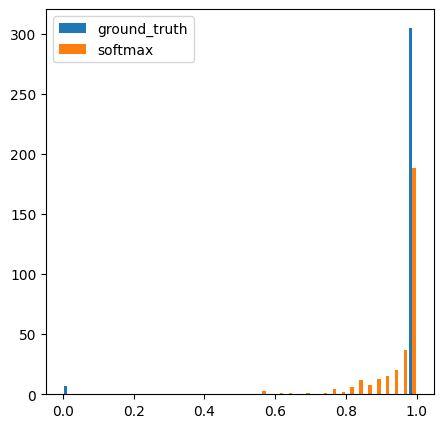

In [ ]:
threshold_energy = np.percentile(normalized_energy.tolist(),60)
query_per90 = [i for i in range(len(query_ids)) if normalized_energy[i]>threshold_energy]
labels = ['ground_truth','softmax']
data=[abs(1-pair_labels[query_per90]),old_softmax[:,0].detach().numpy()[query_per90]]
plt.figure(figsize=(5, 5))
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

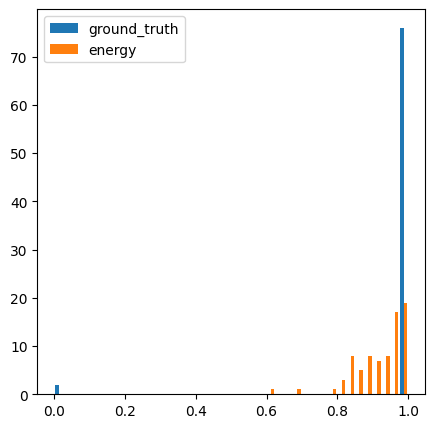

In [ ]:
threshold_energy = np.percentile(old_softmax[:,0].tolist(),90)
query_per90 = [i for i in range(len(query_ids)) if old_softmax[:,0][i]>threshold_energy]
labels = ['ground_truth','energy']
data=[abs(1-pair_labels[query_per90]),normalized_energy.detach().numpy()[query_per90]]
plt.figure(figsize=(5, 5))
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

In [ ]:
len(query_per90)

65

In [ ]:
labels = softmax.argmax(dim=1)
labels = [0 if normalized_energy[i]>=0.5 else 1 for i in range(len(normalized_energy))]


In [ ]:
labels.size()

torch.Size([642])

In [ ]:
sum(np.abs(labels-pair_labels))

246

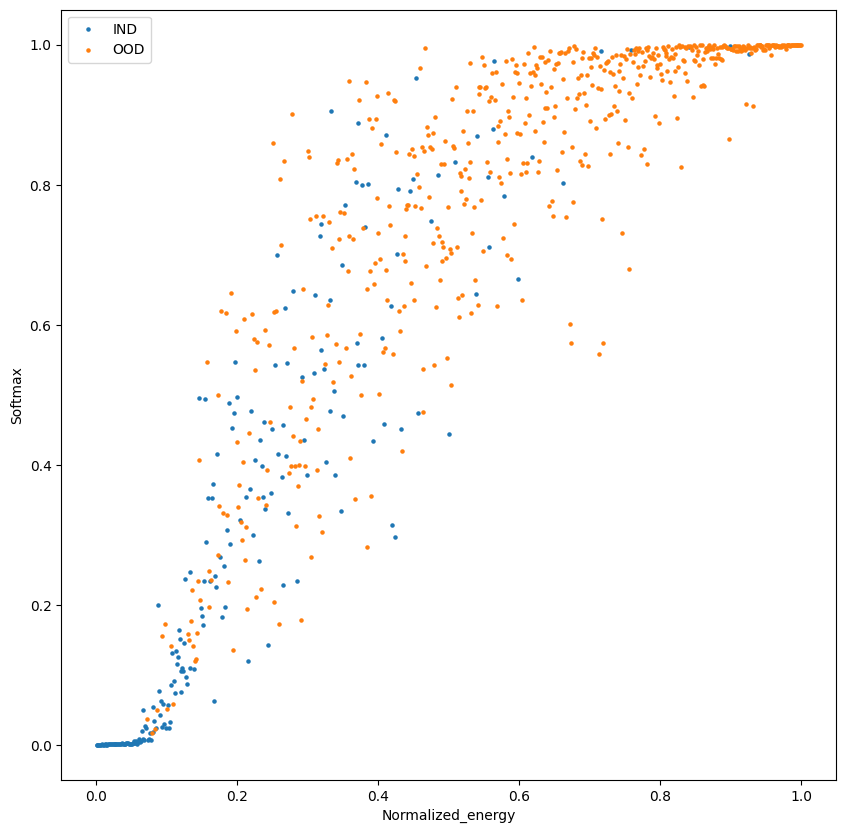

In [ ]:
size = 200 
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_energy.detach().numpy()[query_ind_idx],y = old_softmax[:,0].detach().numpy()[query_ind_idx],label = "IND",s=5)
plt.scatter(x=normalized_energy.detach().numpy()[query_ood_idx],y = old_softmax[:,0].detach().numpy()[query_ood_idx],label = "OOD",s=5)
plt.xlabel("Normalized_energy")
plt.ylabel("Softmax")
plt.legend()
plt.show()

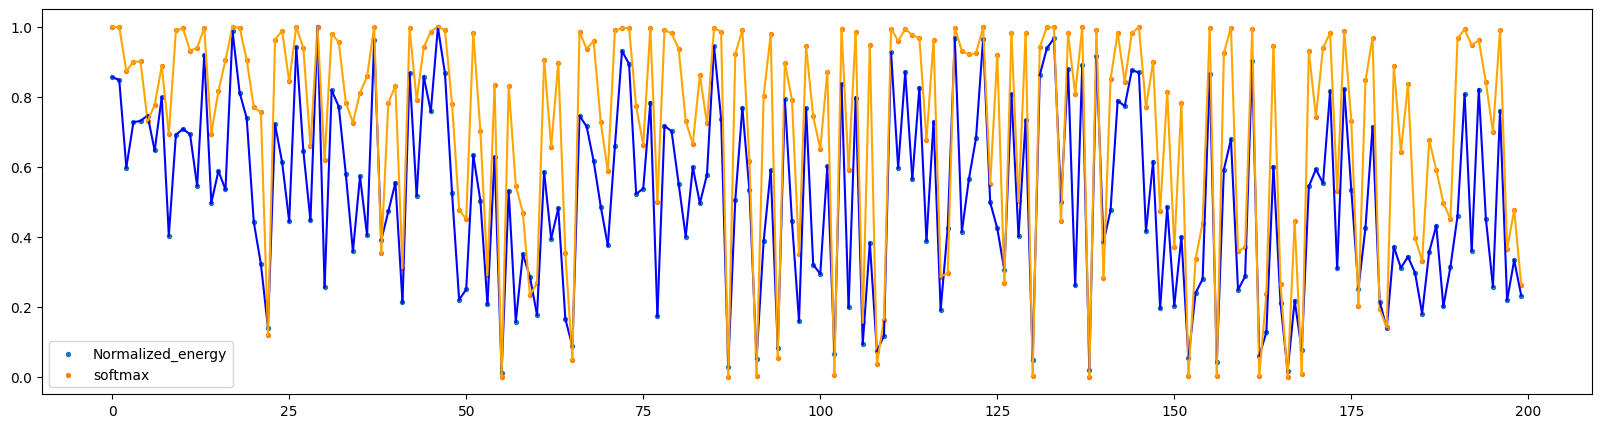

In [ ]:
size = 200
plt.figure(figsize=(20, 5))
plt.scatter(x=range(len(query_ids[:size])),y = normalized_energy.detach().numpy()[:size],s=8,label="Normalized_energy")
plt.scatter(x=range(len(query_ids[:size])),y = old_softmax[:,0].detach().numpy()[:size],s=8,label= "softmax")
for i in range(len(query_ids[:size])-1):
    # plt.plot([i, i],[normalized_energy.detach().numpy()[i], softmax[:,0].detach().numpy()[i]],color='red', linestyle='--')
    plt.plot([i, i+1],[normalized_energy.detach().numpy()[i],normalized_energy.detach().numpy()[i+1]],color='blue')
    plt.plot([i, i+1],[old_softmax[:,0].detach().numpy()[i],old_softmax[:,0].detach().numpy()[i+1]],color='orange')
plt.legend()
plt.show()

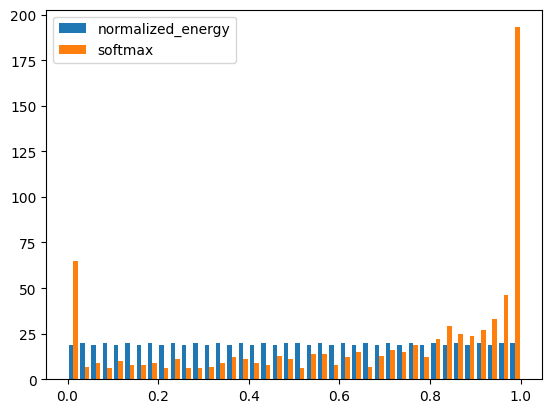

In [ ]:
labels = ['normalized_energy','softmax']
data=[normalized_energy.detach().numpy(),old_softmax[:,0].detach().numpy()]
plt.hist(data,bins =40, label = labels)
plt.legend()
plt.show()

In [ ]:
old_predicted_labels = predicted_labels

In [ ]:
def min_max_norm(data):
    min_val = torch.min(data)
    max_val = torch.max(data)
    return (data - min_val) / (max_val - min_val)

def percentile(x,data):
    return len([data[i] for i in range(len(data)) if data[i]<=x ])/len(data)
def percentile_norm(data):
    return torch.tensor([percentile(data[i],data) for i in range(len(data))])


normalized_energy = percentile_norm(energy_train)
# softmax = torch.softmax(logits,dim=1)



SOFTMAX

In [ ]:
alpha = 1
from scipy.special import softmax
old_softmax = torch.softmax(logits,dim=-1)
new1_softmax=old_softmax.detach().cpu().numpy()
new1_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
new1_softmax = softmax(new1_softmax,axis=-1)
predicted1_labels = new1_softmax.argmax(axis=1)

from sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
fpr, tpr, thresholds = sklearn.metrics.roc_curve(pair_labels, new1_softmax[:,1], pos_label=1)
auc = sklearn.metrics.auc(fpr, tpr)
f1_macro = f1_score(pair_labels, predicted1_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted1_labels, average='micro')
f1 = f1_score(pair_labels, predicted1_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted1_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted1_labels, labels=[0], average=None)[0]

print(f"AUC:          {round(auc,6)}")
print(f"f1_macro:     {round(f1_macro,6)}")
print(f"f1_micro:     {round(f1_micro,6)}")
print(f"recall_true:  {round(recall_true_class,6)}")
print(f"f1_false:     {round(f1_false_class,6)}")
print(f"recall_false: {round(recall_false_class,6)}")


AUC:          0.679893
f1_macro:     0.64902
f1_micro:     0.65528
recall_true:  0.753709
f1_false:     0.602151
recall_false: 0.547231


Alpha:              0.8
AUC:                0.747666
f1_macro:           0.686109
f1_micro:           0.697819
recall_true_class:  0.85119
f1_false_class:     0.625483
recall_false_class: 0.529412

AUC:                0.748648
f1_macro:           0.681228
f1_micro:           0.694704
recall_true_class:  0.860119
f1_false_class:     0.615686
recall_false_class: 0.513072

1-softmax

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
old_softmax = torch.softmax(logits,dim=-1)


# new_softmax = old_softmax.detach().cpu().numpy()
# new_softmax[:,0] = alpha* old_softmax[:,0].detach().cpu().numpy() + (1-alpha)*normalized_energy.detach().cpu().numpy()
# new_softmax[:,1] = 1-new_softmax[:,0]/(new_softmax[:,1]+new_softmax[:,0])
# new_softmax[:,0] = 1.0 - new_softmax[:,1]
predicted_labels = old_softmax.detach().cpu().numpy().argmax(axis=1)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(pair_labels, old_softmax[:,1], pos_label=1)
auc = sklearn.metrics.auc(fpr, tpr)
f1_macro = f1_score(pair_labels, predicted_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted_labels, average='micro')
f1 = f1_score(pair_labels, predicted_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
print(f"AUC:                {round(auc,6)}")
print(f"f1_macro:           {round(f1_macro,6)}")
print(f"f1_micro:           {round(f1_micro,6)}")
print(f"recall_true_class:  {round(recall_true_class,6)}")
print(f"f1_false_class:     {round(f1_false_class,6)}")
print(f"recall_false_class: {round(recall_false_class,6)}")


AUC:                0.647186
f1_macro:           0.502613
f1_micro:           0.505452
recall_true_class:  0.821429
f1_false_class:     0.540188
recall_false_class: 0.39346


TEST APPROACH 2

In [ ]:
sum(abs(predicted_labels - predicted1_labels))

0

In [ ]:

softmax = torch.softmax(logits,dim=1)
predicted_labels = softmax.argmax(dim=1)
threshold = -1
predicted_labels = [0 if energy_train[i] > threshold else predicted_labels[i] for i in range(predicted_labels.size(0))]
predicted_labels = torch.tensor([x for x in predicted_labels])

In [ ]:
test = []
for i in range(old_predicted_labels.size(0)):
    if (energy_train[i] > threshold and old_predicted_labels[i]==1):
        test.append(old_predicted_labels[i])
print(len(test))

NameError: name 'old_predicted_labels' is not defined

In [ ]:
print(predicted_labels-old_predicted_labels)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0, 

In [ ]:

f1_macro = f1_score(pair_labels, predicted_labels, average='macro')
f1_micro = f1_score(pair_labels, predicted_labels, average='micro')
f1 = f1_score(pair_labels, predicted_labels)

# this is the normal precision and recall we seen so many times
precision_true_class = precision_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
recall_true_class = recall_score(pair_labels, predicted_labels, labels=[1], average=None)[0]
f1_true_class = f1_score(pair_labels, predicted_labels, labels=[1], average=None)[0]

precision_false_class = precision_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
recall_false_class = recall_score(pair_labels, predicted_labels, labels=[0], average=None)[0]
f1_false_class = f1_score(pair_labels, predicted_labels, labels=[0], average=None)[0]

f1_macro:0.774153396452175
f1_micro:0.7780898876404494
recall_true_class:0.8709677419354839
f1_false_class:0.7443365695792881
recall_false_class:0.6764705882352942

In [ ]:

print(f"f1_macro:{f1_macro}")
print(f"f1_micro:{f1_micro}")
print(f"recall_true_class:{recall_true_class}")
print(f"f1_false_class:{f1_false_class}")
print(f"recall_false_class:{recall_false_class}")

f1_macro:0.774153396452175
f1_micro:0.7780898876404494
recall_true_class:0.8709677419354839
f1_false_class:0.7443365695792881
recall_false_class:0.6764705882352942


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

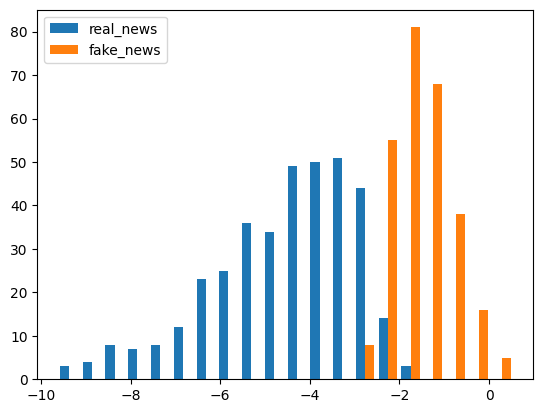

In [ ]:
labels = ['real_news','fake_news']
data=[energy_train.detach().numpy()[query_real_idx],energy_train.detach().numpy()[query_fake_idx]]
plt.hist(data,bins =20, label = labels)
plt.legend()
plt.show()

In [ ]:
def plot_kde(data, x_label, title):
  kde_obj = kde.gaussian_kde(data)

  x_grid = np.linspace(data.min(), data.max(), 400)
  density = kde_obj(x_grid)

  plt.plot(x_grid, density, label='KDE')

  plt.xlabel(x_label)
  plt.ylabel('Density')
  plt.title(title)
  plt.grid(True)
  plt.show()

/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_74024/198493470.py:1: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])
/var/folders/s1/ttyz18893hn76tz48dhzp9cr0000gn/T/ipykernel_74024/198493470.py:6: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])


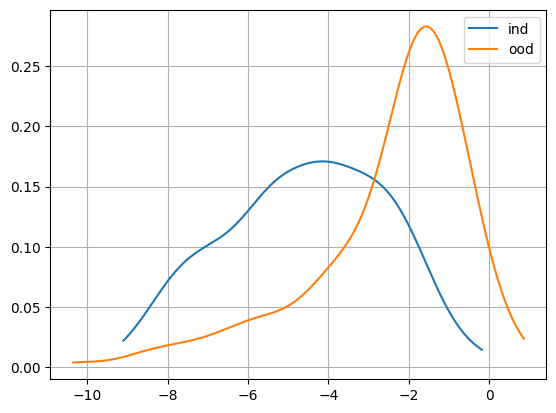

In [ ]:

kde_obj_ind = kde.gaussian_kde(energy_train.detach().numpy()[query_ind_idx])

x_ind = np.linspace(energy_train.detach().numpy()[query_ind_idx].min(), energy_train.detach().numpy()[query_ind_idx].max(), 400)
density_ind = kde_obj_ind(x_ind)
plt.plot(x_ind, density_ind, label='ind')
kde_obj_ood = kde.gaussian_kde(energy_train.detach().numpy()[query_ood_idx])

x_ood = np.linspace(energy_train.detach().numpy()[query_ood_idx].min(), energy_train.detach().numpy()[query_ood_idx].max(), 400)

density_ood = kde_obj_ood(x_ood)

plt.plot(x_ood, density_ood, label='ood')

# Set labels and title.
# plt.xlabel(x_label)
# plt.ylabel('Density')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# predictions = match_model.predict(left_contents[:1], evd_docs_contents[:1], **additional_paramters)
phi,output,avg,query_repr,doc_out_ggnn,query_repr1,avg1 = match_model.predict(left_contents, evd_docs_contents, **additional_paramters)


In [ ]:
type(output)

torch.Tensor

Test Percentile 

TEST LABEL PROBAGATION

Shape of Word Embeddings: torch.Size([2, 15, 384])
Sentence embeddings: torch.Size([2, 384])


In [ ]:
query_ids, left_contents, left_lengths, query_sources, query_char_sources, query_adj, \
            evd_docs_ids, evd_docs_contents, evd_docs_lens, evd_sources, evd_cnt_each_query, evd_char_sources, \
            pair_labels, evd_docs_adj = fit_model._sampler.get_train_instances_char_man(predict_interactions,fit_model.fixed_num_evidences)

In [ ]:
query_lens = torch.tensor(left_lengths)
adj = torch.tensor(query_adj).float()

In [ ]:
query=torch.tensor(left_contents)
query_mask = (query > 0).unsqueeze(2)
query_lens = query_lens.unsqueeze(-1) 
embed_query = embed_sentence  # (B, L, D)

In [ ]:
embed_query.shape

torch.Size([782, 30, 384])

In [ ]:
query_length = 30
from transformers import AutoTokenizer, AutoModel
import torch
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5')
model.eval()


def convert_query2sentence(query):
    str = ""
    for ele in query:
        for key, value in term_index.items():
            if value == ele and key!="<PAD>":
                str+=key
                str+=" "
                break
    return str[:-1]
def get_count_word(sentence):
    count_word = list()
    s = sentence.split(" ")
    for ele in s :
        count_word.append(len(tokenizer.tokenize(ele)))
    return count_word

def convert2embed_sentence(tuple_query,query_length):
    padding = tuple_query[0][-1]
    embed_sentence_0 = tuple_query[0][1:-1]
    embed_sentence = list()

    for count in tuple_query[1]:
        embed_word = embed_sentence_0[:count]
        embed_word = torch.sum(embed_word,dim = 0)
        embed_word = torch.nn.functional.normalize(embed_word, p=2, dim=0)
        embed_sentence_0 = embed_sentence_0[count:]
        embed_sentence.append(embed_word.detach().cpu().numpy())

    while(len(embed_sentence)<query_length):
        embed_sentence.append(padding.detach().cpu().numpy())

    return np.array(embed_sentence)

def embedding_query(query,length):
    list_left_content =[convert_query2sentence(x) for x in query]
    list_count_word = [get_count_word(x) for x in list_left_content]
    encoded_input = tokenizer(list_left_content, padding=True, truncation=True, return_tensors='pt')
    model_output = model(**encoded_input)
    last_hidden_state = torch.nn.functional.normalize(model_output.last_hidden_state, p=2, dim=1)
    embed_sentence = torch.tensor([convert2embed_sentence(x,length) for x in list(zip(last_hidden_state,list_count_word))])
    return embed_sentence

In [ ]:
evd_docs_contents.shape

(782, 30, 100)

In [ ]:
embed_sentence = embedding_query(left_contents)

In [ ]:
embed_sentence.size()

torch.Size([782, 30, 384])

In [ ]:
encoded_text = tokenizer.encode(text, return_tensors='pt') 
decoded_text = tokenizer.decode(encoded_text.squeeze(), skip_special_tokens=True)

In [ ]:
doc = evd_docs_contents

In [ ]:
doc.shape

(782, 30, 100)

In [ ]:
e_conts.shape

torch.Size([62, 100])

In [ ]:
test = embedding_query(e_conts[:2],100)

torch.Size([2, 100, 384])

In [ ]:
e_conts[0]

tensor([31040, 18804, 23242, 19839,  9258, 10489, 35467, 33030, 34789, 32805,
        39824, 17332, 22894, 44944, 24272, 32440, 32249, 44934, 17665, 20683,
        12320, 49420, 26528, 22481, 45412, 42856, 39219, 32456, 49228, 11132,
        15587, 36026, 49869, 19082, 23986, 39655, 34283, 17001, 35463, 44873,
        49311, 10277, 40654, 48436, 36853,  8505,  2531, 34406,  4143, 22471,
        37148, 45467, 15962, 12030, 31326, 44924, 17162, 19941,  6908,  5616,
         3670, 31486,  8713, 22195, 34712, 29630, 20181,  4070, 35266, 32430,
         7266, 30867, 34138, 46244,  3870, 35663, 18943,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
test = embedding_query(e_conts[:30],100)

In [ ]:
doc_mask[0]

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])